# SPGR

In [1]:
import version_control

Last run on cashlab03-deb at 2015-03-26 16:21:14.760740

Phypno Version: 01ade7cd0403c2fb7015744a0e2642e9dee19871

Babel==1.3, Cython==0.22, Jinja2==2.7.3, Markdown==2.6.1, MarkupSafe==0.23, Pillow==2.7.0, PyOpenGL==3.1.0, Pygments==2.0.2, Sphinx==1.3.1, alabaster==0.7.3, bash-kernel==0.3, beautifulsoup4==4.3.2, biopython==1.65, certifi==14.05.14, coverage==3.7.1, decorator==3.4.2, docutils==0.12, easydev==0.8.3, ipython==3.0.0, jedi==0.8.1-final0, jsonschema==2.4.0, matplotlib==1.4.3, memory-profiler==0.32, mistune==0.5.1, networkx==1.9.1, nibabel==2.0.0, nitime==0.5, nltk==3.0.2, nose==1.3.4, numpy==1.9.2, numpydoc==0.5, ordereddict==1.1, pandas==0.16.0, pandocfilters==1.2.3, pep8==1.6.2, pexpect==3.3, pockets==0.2.4, psutil==2.2.1, pycurl==7.19.5.1, pyflakes==0.8.1, pyparsing==2.0.3, pyqtgraph==0.9.10, python-dateutil==2.4.1, python-igraph==0.7.1-4, pytz==2015.2, pyzmq==14.5.0, requests==2.6.0, rope-py3k==0.9.4-1, rpy2==2.5.6, scikit-learn==0.15.2, scipy==0.15.1, six==1.9.0, snowbal

In [2]:
from spgr import lg
lg.setLevel(10)

## Spindle Detection Method

In [3]:
from copy import deepcopy
from numpy import where, NaN
from pathlib import Path

from spgr.read_data import DATA_DIR, REC_DIR, FS_PATH, ELEC_PATH, get_data, GROUP_DIR
GROUP_DIR = Path(GROUP_DIR)

In [29]:
images_dir = GROUP_DIR.joinpath('images').joinpath('methods')
try:
    images_dir.mkdir()
except FileExistsError:
    pass

PLOT_COLOR = 'kw'

In [5]:
from phypno.detect import DetectSpindle
from phypno.detect.spindle import transform_signal
from phypno.trans import Select

In [6]:
options = {'reref': 'avg',
           'resample_freq': 256,
           'hp_filter': 0.5,
           'lp_filter': 50,
           }
chan_type = ('grid', 'strip')

Spindles were detected on each electrode independently, using previously reported methods with stringent criteria [@Nir2011_regional].
The raw signal was filtered between 9 and 16 Hz and the instantaneous amplitude was calculated from the analytic signal via Hilbert transform.
The amplitude had to go above a threshold for detection (set at 3 times the S.D.).
The beginning and end of the spindle were defined by a threshold for selection (set at 1 time the S.D.).
Spindle duration had to be between 0.5 and 2s.
We computed the power spectrum over the spindle interval and the peak in the power spectrum had to lie between 9 and 16 Hz (Fig. +[spgr_detect_method]).

In [7]:
LIMITS = (9, 16)

detsp = DetectSpindle(method='Nir2011', frequency=LIMITS, duration=(0.5, 2))

In [8]:
PLOT_SIZE = 960, 240

In [9]:
subj = 'EM09'
chan_name = 'GR28'
data = get_data(subj, 'sleep', chan_type, **options)
sel = Select(chan=(chan_name, ))
data = sel(data)

INFO:/home/gio/projects/spgr/scripts/spgr/read_data.py:Subj EM09, reading data: EM09_sleep_grid-strip_hp005_lp500_rs256.pkl
INFO:/home/gio/projects/spgr/scripts/spgr/read_data.py:EM09 analysis chan 77, with location 77


In [10]:
good_trial = [i for i, trl in enumerate(data) if 42710 // 30 * 30 == trl.axis['time'][0][0]][0]
good_trial = 73

In [11]:
sel = Select(trial=(good_trial, ))
sel_data = sel(data)

In [12]:
from phypno.viz import Viz1

In [13]:
select_beginning = Select(time=(None, 44852))
one_spindle_data = select_beginning(sel_data)

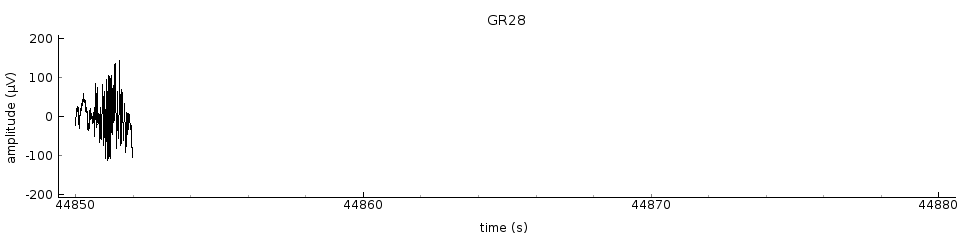

In [20]:
v = Viz1(color=PLOT_COLOR)
v.size = PLOT_SIZE
v.add_data(one_spindle_data, limits_x=(44850, 44880), limits_y=(-200, 200))
v._plots[chan_name].setLabels(left='amplitude (μV)', bottom='time (s)')
v.save(str(images_dir.joinpath('raw_spindle.png' )))
v

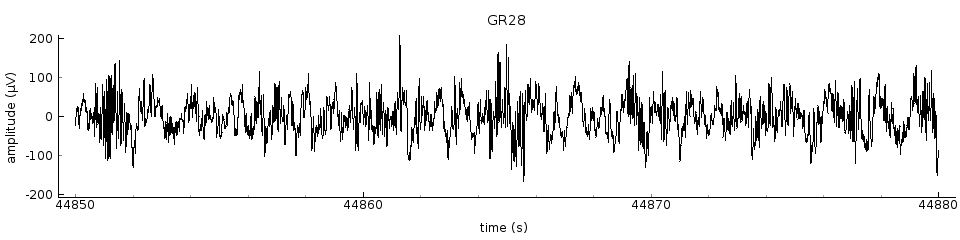

In [19]:
v = Viz1(color=PLOT_COLOR)
v.size = PLOT_SIZE
v.add_data(sel_data, limits_x=(44850, 44880), limits_y=(-200, 200))
v._plots[chan_name].setLabels(left='amplitude (μV)', bottom='time (s)')
v.save(str(images_dir.joinpath('raw.png' )))
v

In [23]:
sp = detsp(sel_data)

/home/gio/tools/venv/lib/python3.4/site-packages/numpy/core/numeric.py:183: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)


In [25]:
from phypno.trans import Filter, Math

filt = Filter(low_cut=detsp.det_butter['freq'][0], high_cut=detsp.det_butter['freq'][1], 
              order=detsp.det_butter['order'], s_freq=data.s_freq)
x_filt = filt(sel_data)

In [26]:
from numpy import ones, take, swapaxes, arange, atleast_2d
from scipy.signal import fftconvolve

def move_avg(dat, axis):
    """Function to compute moving average."""
    flat = ones(detsp.moving_avg['dur'] * data.s_freq)

    dat = swapaxes(dat, axis, -1)
    for i, x in enumerate(dat):
        dat[i, :] = fftconvolve(x, flat / sum(flat), mode='same')
    return swapaxes(dat, -1, axis)

hilbert_abs = Math(operator_name=('hilbert', 'abs'), axis='time')
moving_avg = Math(operator=move_avg, axis='time')

dat_det = moving_avg(hilbert_abs(x_filt))

/home/gio/tools/venv/lib/python3.4/site-packages/numpy/core/numeric.py:183: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)


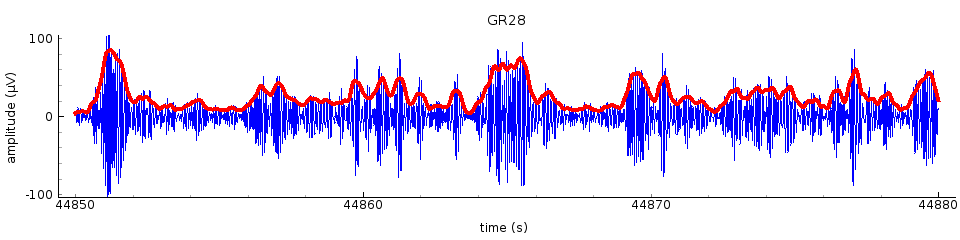

In [30]:
from pyqtgraph import mkPen

v = Viz1(color=PLOT_COLOR)
v.size = PLOT_SIZE
v.add_data(x_filt, color=mkPen('b', width=1), limits_x=(44850, 44880), limits_y=(-100, 100))
v.add_data(dat_det, color=mkPen('r', width=4))
v._plots[chan_name].setLabels(left='amplitude (μV)', bottom='time (s)')
v.save(str(images_dir.joinpath('envelope.png' )))
v

In [33]:
t = dat_det.axis['time'][0]
good_sp = [x for x in sp.spindle if x['start_time'] < t[-1] and x['end_time'] > t[0]]

detected_spindles = deepcopy(dat_det)

for one_sp in good_sp:
    i0 = where(t == one_sp['start_time'])[0]
    i1 = where(t == one_sp['end_time'])[0]
    detected_spindles.data[0][0, i0:i1] = NaN

/home/gio/tools/venv/lib/python3.4/site-packages/IPython/kernel/__main__.py:9: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


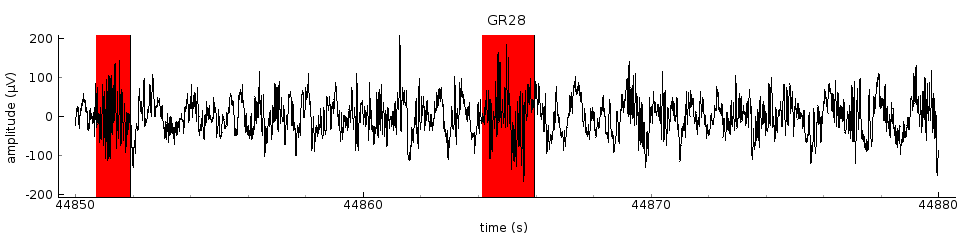

In [35]:
v = Viz1(color=PLOT_COLOR)
v.size = PLOT_SIZE
v.add_data(sel_data, limits_x=(44850, 44880), limits_y=(-200, 200))
v._plots[chan_name].setLabels(left='amplitude (μV)', bottom='time (s)')
v.add_graphoelement(sp)
v.save(str(images_dir.joinpath('detected.png' )))
v

In [36]:
from phypno.trans import Math, Filter
from numpy import pi

/home/gio/tools/venv/lib/python3.4/site-packages/numpy/core/numeric.py:183: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)


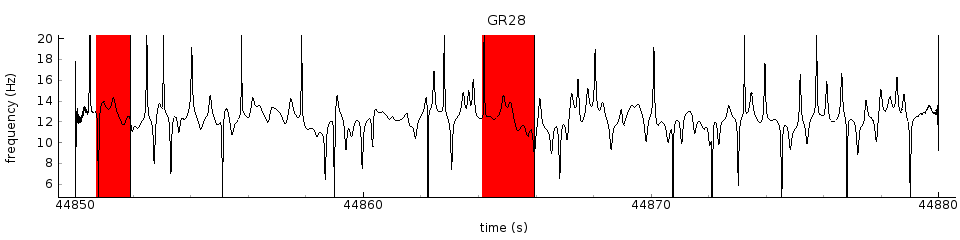

In [38]:
sel = Select(trial=(73, ))
sel_data = sel(data)
sp = detsp(sel_data)

hp = Filter(low_cut=10, high_cut=15, s_freq=sel_data.s_freq)
h = Math(operator_name=('hilbert', 'angle', 'unwrap', 'diff'), axis='time')
ddata = h(hp(sel_data))
ddata.data[0] *= (ddata.s_freq / 2 / pi)

v = Viz1(color=PLOT_COLOR)
v.size = PLOT_SIZE
v.add_data(ddata, limits_x=(44850, 44880), limits_y=(5, 20))
v.add_graphoelement(sp)
v._plots[chan_name].setLabels(left='frequency (Hz)', bottom='time (s)')
v.save(str(images_dir.joinpath('inst_freq.png' )))
v

### All Subjects

In [ ]:
hemi_subj = {'EM09': 'rh', 
             'MG17': 'rh',
             'MG33': 'lh',
             'MG37': 'lh',
             'MG61': 'lh',
             'MG63': 'rh',
             }
all_subj = sorted(hemi_subj.keys())

In [ ]:
from spgr.detect_spindles import get_spindles

In [ ]:
options = {'reref': 'avg',  # or 15 or ''
           'resample_freq': 256,
           'hp_filter': 0.5,
           'lp_filter': 50,
           }
chan_type = ('grid', )

In [ ]:
for subj in all_subj:
    print(subj)
    sp = get_spindles(subj, chan_type=chan_type, **options)    

In [ ]:
subj = all_subj[0]

In [ ]:
data = get_data(subj, 'sleep', chan_type, **options)

In [ ]:
spindles_options = {'method': 'Nir2011', 
                    'frequency': (9, 16), 
                    'duration':(0.5, 2),
                    }
options.update(spindles_options)

In [ ]:
sp = get_spindles(subj, **options) 